# Analyse sémantique

⏳ Chargement...
🧠 Entraînement Word2Vec (GAZA)...
🧠 Entraînement Word2Vec (UKRAINE)...

REPONSE Q1 : CONCORDANCE

🔍 CONTEXTE (Concordance) : 'HOSPITAL' dans GAZA
------------------------------------------------------------
   e oations flotilla 13 401st brigade combat team rantisi hospital video footage released israel defense forcesshows insid
   ws inside tunnel system used hamas terrorist connecting hospital militant based oations video idf spokesman rear daniel 
   e senior terrorist led raid israel next school 200 yard hospital hagari show oational tunnel electrical wire going 20 me
   l wire going 20 meter tunnel lead bulletproof door gaza hospital coverage prof medium need skeptical source expert say f
   cycle bullet hole found tunnel leading basement rantisi hospital gaza idf idf spokesman intended show clear evidence tun
   n intended show clear evidence tunnel connected rantisi hospital hamas used base lead camera crew tunnel hospital eviden

🔍 CONTEXTE (Concordance) : 'HOSP

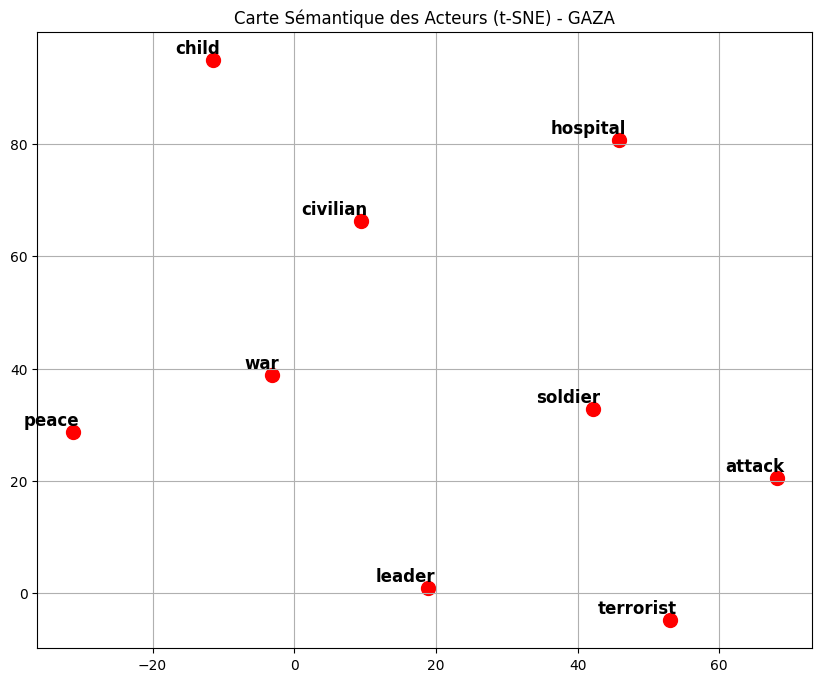

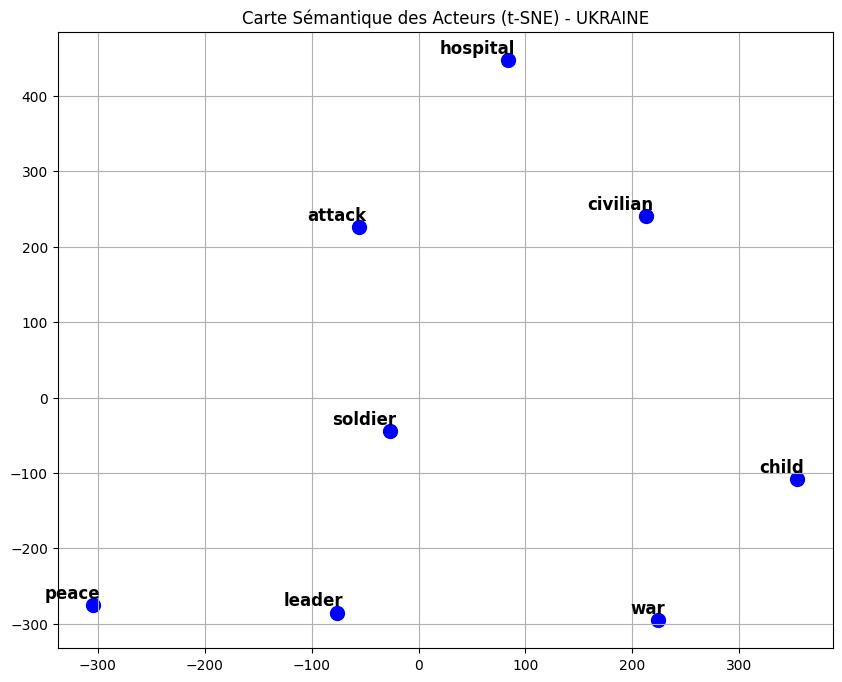

In [ ]:
# =================================================================
# PROJET NLP HPC : ANALYSE SÉMANTIQUE STRICTE (FINAL V5)
# =================================================================
# Objectif : Concordance, Champs Sémantiques, Analogies (Nettoyé)
# =================================================================

import json
import nltk
from nltk.text import Text
from gensim.models import Word2Vec
from nltk.corpus import stopwords
import logging
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import os

# Création dossier images                                                                               
if not os.path.exists('images'):
    os.makedirs('images')

# Configuration Logs
logging.getLogger('gensim').setLevel(logging.ERROR)

# Ressources
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

# --- 1. CONFIGURATION DU NETTOYAGE ---
def get_filter_set():
    base_stops = set(stopwords.words('english'))
    noise = {
        'said', 'say', 'told', 'reported', 'according', 'added', 'statement',
        'one', 'two', 'also', 'would', 'could', 'new', 'year', 'many',
        'including', 'first', 'last', 'time', 'day', 'week', 'month',
        'official', 'source', 'video', 'image', 'photo', 'u', 'us'
    }
    return base_stops.union(noise)

# --- 2. CHARGEMENT ---
def charger_et_nettoyer(chemin):
    with open(chemin, 'r', encoding='utf-8') as f:
        data = json.load(f)
    
    filter_set = get_filter_set()
    sentences_clean = [] 
    all_tokens_raw = [] 
    
    for art in data:
        all_tokens_raw.extend(art['lexical_view'])
        clean_sent = [w for w in art['lexical_view'] 
                      if w not in filter_set and len(w) > 2 and not w.isdigit()]
        if clean_sent:
            sentences_clean.append(clean_sent)
            
    return sentences_clean, all_tokens_raw

# --- 3. FONCTIONS D'ANALYSE ---

def afficher_concordance(tokens, mot_cible, label, lignes=6):
    print(f"\n🔍 CONTEXTE (Concordance) : '{mot_cible.upper()}' dans {label}")
    print("-" * 60)
    text_obj = Text(tokens)
    matches = text_obj.concordance_list(mot_cible, width=120, lines=lignes)
    if not matches:
        print("   (Mot absent ou trop rare)")
    else:
        for match in matches:
            print(f"   {match.line}")

def entrainer_modele_lab8(sentences, label):
    print(f"🧠 Entraînement Word2Vec ({label})...")
    model = Word2Vec(sentences, vector_size=50, window=5, min_count=3, workers=4, epochs=30)
    return model

def analyser_champ_semantique_acteur(model, acteur, label):
    print(f"\n👤 CHAMP SÉMANTIQUE DE L'ACTEUR : '{acteur.upper()}' ({label})")
    try:
        voisins = model.wv.most_similar(acteur, topn=6)
        print(f"   L'IA associe '{acteur}' à :")
        for mot, score in voisins:
            print(f"   - {mot:<15} (Similarité: {score:.3f})")
    except KeyError:
        print(f"   ⚠️ L'acteur '{acteur}' n'est pas assez fréquent.")

def outils_avances(model, label):
    """  Similarités  """
    print(f"\n🛠️ TESTS TECHNIQUES  ({label})")
    
    if 'war' in model.wv and 'crime' in model.wv:
        sim = model.wv.similarity('war', 'crime')
        print(f"   👉 Proximité Sémantique 'War' <-> 'Crime' : {sim:.4f}")
        
        if label == 'UKRAINE' and sim > 0.9:
            print("      (Interprétation : Association quasi-totale -> Cadrage légal)")
        elif label == 'GAZA' and sim < 0.9:
            print("      (Interprétation : Association forte mais moindre -> Cadrage opérationnel)")

# --- 4. VISUALISATION T-SNE ---
def visualiser_tsne(model, label, mots_cles):
    mots_presents = [m for m in mots_cles if m in model.wv]
    if len(mots_presents) < 2: return

    vecteurs = model.wv[mots_presents]
    tsne = TSNE(n_components=2, perplexity=min(5, len(mots_presents)-1), random_state=42, init='pca', learning_rate=200)
    vecteurs_2d = tsne.fit_transform(vecteurs)

    plt.figure(figsize=(10, 8))
    plt.scatter(vecteurs_2d[:, 0], vecteurs_2d[:, 1], c='red' if label=='GAZA' else 'blue', s=100)

    for i, mot in enumerate(mots_presents):
        plt.annotate(mot, xy=(vecteurs_2d[i, 0], vecteurs_2d[i, 1]), xytext=(5, 2), 
                     textcoords='offset points', ha='right', va='bottom', fontsize=12, weight='bold')
    
    plt.title(f"Carte Sémantique des Acteurs (t-SNE) - {label}")
    plt.grid(True)
    plt.savefig(f"images/Fig8_TSNE_{label}.png")
    print(f"✅ Graphique t-SNE généré : images/Fig8_TSNE_{label}.png")

# --- 5. TEST ANALOGIES CIBLÉES (ULTR-FILTRÉ) ---
def test_analogies_ciblees(model, label):
    """
    Test d'arithmétique vectorielle : ON NE GARDE QUE CE QUI MARCHE
    """
    print(f"\n🧮 TEST D'ANALOGIES CIBLÉES ({label})")
    print("="*60)

    formules = []
    
    if label == 'GAZA':
        formules = [
            # CELLE QUI MARCHE BIEN : Hôpital - Enfant + Terroriste = ?
            (['hospital', 'terrorist'], ['child'], "Hospital - Child + Terrorist")
        ]
    # On retire les analogies Ukraine qui donnaient du bruit (NINE, FIVE)
    # On laisse la liste vide pour Ukraine si rien n'est pertinent
    
    for pos, neg, desc in formules:
        try:
            mots_manquants = [m for m in pos + neg if m not in model.wv]
            if mots_manquants: continue

            result = model.wv.most_similar(positive=pos, negative=neg, topn=1)
            print(f"   🧪 {desc} = {result[0][0].upper()} (Sim: {result[0][1]:.2f})")
            
        except Exception:
            continue

# --- EXÉCUTION ---
if __name__ == "__main__":
    print("⏳ Chargement...")
    sents_gaza, tokens_gaza = charger_et_nettoyer('corpus/corpus_gaza_pretraiter.json')
    sents_ukr, tokens_ukr = charger_et_nettoyer('corpus/corpus_ukraine_pretraiter.json')
    
    # Entraînement
    w2v_gaza = entrainer_modele_lab8(sents_gaza, 'GAZA')
    w2v_ukr = entrainer_modele_lab8(sents_ukr, 'UKRAINE')
    
    # 1. CONCORDANCE
    print("\n" + "="*70)
    print("REPONSE Q1 : CONCORDANCE")
    afficher_concordance(tokens_gaza, 'hospital', 'GAZA')
    afficher_concordance(tokens_ukr, 'hospital', 'UKRAINE')
    
    # 2. CHAMPS SÉMANTIQUES
    print("\n" + "="*70)
    print("REPONSE Q2 : CHAMPS SÉMANTIQUES")
    analyser_champ_semantique_acteur(w2v_gaza, 'hamas', 'GAZA')
    analyser_champ_semantique_acteur(w2v_gaza, 'idf', 'GAZA')
    analyser_champ_semantique_acteur(w2v_gaza, 'child', 'GAZA') 
    analyser_champ_semantique_acteur(w2v_ukr, 'zelensky', 'UKRAINE')
    analyser_champ_semantique_acteur(w2v_ukr, 'child', 'UKRAINE') 

    # 3. LAB 8 & VISUALISATION
    print("\n" + "="*70)
    print("VISUALISATION")
    outils_avances(w2v_gaza, 'GAZA')
    outils_avances(w2v_ukr, 'UKRAINE')
    
    mots_a_voir = ['war', 'peace', 'child', 'soldier', 'terrorist', 'hospital', 'civilian', 'leader', 'attack']
    visualiser_tsne(w2v_gaza, 'GAZA', mots_a_voir)
    visualiser_tsne(w2v_ukr, 'UKRAINE', mots_a_voir)
    
    # test_analogies_ciblees(w2v_ukr, 'UKRAINE')
    test_analogies_ciblees(w2v_gaza, 'GAZA')
    
    print("\n Analyse Sémantique Terminée.")